In [ ]:
# --- 📦 IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
# Feature Selection & Extraction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, f_classif, RFE

In [ ]:
# --- 📥 LOAD & CHECK DATA ---
data = pd.read_csv('sample_data/Covid Dataset.csv')
print("Initial Data Info:")
data.info()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Breathing Problem                        5434 non-null   object
 1   Fever                                    5434 non-null   object
 2   Dry Cough                                5434 non-null   object
 3   Sore throat                              5434 non-null   object
 4   Running Nose                             5434 non-null   object
 5   Asthma                                   5434 non-null   object
 6   Chronic Lung Disease                     5434 non-null   object
 7   Headache                                 5434 non-null   object
 8   Heart Disease                            5434 non-null   object
 9   Diabetes                                 5434 non-null   object
 10  Hyper Tension                            

In [ ]:
# Check for custom missing strings
def check_custom_missing(df):
    custom_missing = ["", "?", "NA", "N/A", "null", "none", "None", "Missing"]
    for val in custom_missing:
        print(f"Custom missing '{val}':", (df == val).sum().sum())

check_custom_missing(data)


Custom missing '': 0
Custom missing '?': 0
Custom missing 'NA': 0
Custom missing 'N/A': 0
Custom missing 'null': 0
Custom missing 'none': 0
Custom missing 'None': 0
Custom missing 'Missing': 0


In [ ]:
# --- 🧹 DATA CLEANING ---
mapping = {'Yes': 1, 'No': 0}
data_encoded = data.replace(mapping)

selected_features = [
    'Fever', 'Dry Cough', 'Breathing Problem', 'Fatigue ', 'Sore throat', 'Headache',
    'Contact with COVID Patient', 'Visited Public Exposed Places',
    'Attended Large Gathering', 'Family working in Public Exposed Places', 'Abroad travel'
]

X = data_encoded[selected_features]
y = data_encoded['COVID-19']


<ipython-input-20-bd5cf9f3354f>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


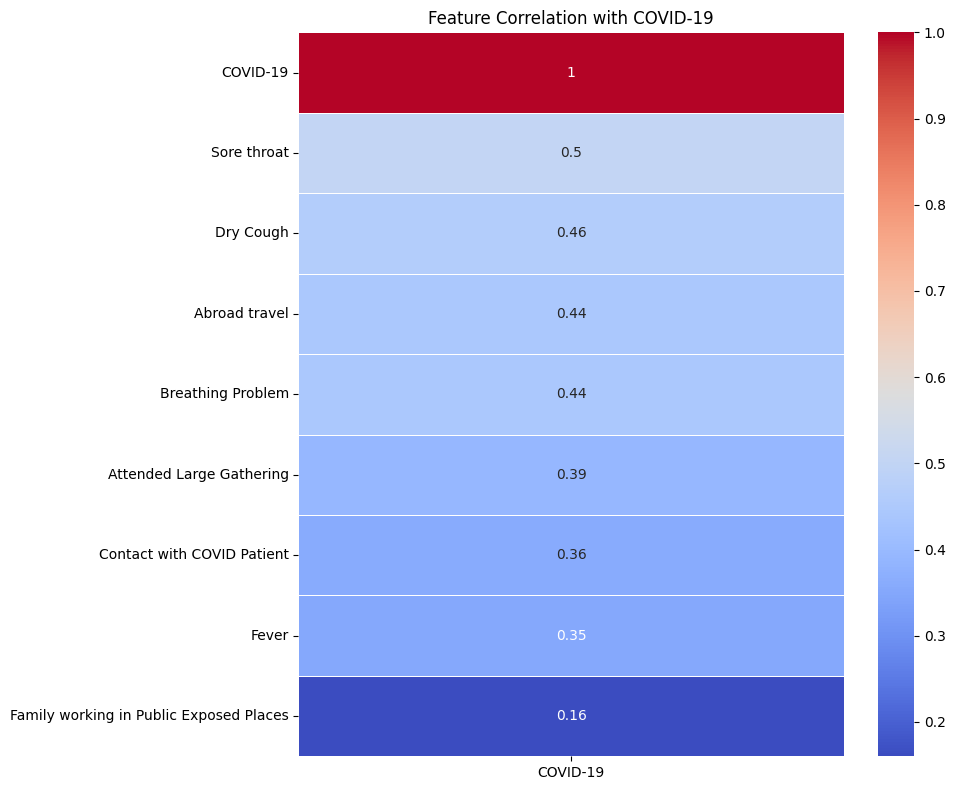

In [ ]:
# --- 🔥 HEATMAP OF FEATURE CORRELATION ---
plt.figure(figsize=(10, 8))
correlation_matrix = data_encoded[selected_features + ['COVID-19']].corr()
sns.heatmap(correlation_matrix[['COVID-19']].sort_values(by='COVID-19', ascending=False), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation with COVID-19')
plt.tight_layout()
plt.show()

In [ ]:
# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# --- FEATURE SELECTION & EXTRACTION METHODS ---
methods = {}

# PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
methods['PCA'] = (X_train_pca, X_test_pca)

# LDA (needs class labels)
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)
methods['LDA'] = (X_train_lda, X_test_lda)

# SelectKBest
skb = SelectKBest(score_func=f_classif, k=5)
X_train_skb = skb.fit_transform(X_train_scaled, y_train)
X_test_skb = skb.transform(X_test_scaled)
methods['SelectKBest'] = (X_train_skb, X_test_skb)

# RFE with SVM
svm_for_rfe = SVC(kernel="linear")
rfe = RFE(estimator=svm_for_rfe, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)
methods['RFE'] = (X_train_rfe, X_test_rfe)


In [ ]:
# --- MODEL EVALUATION LOOP ---
print("\n======== MODEL COMPARISON (SVM with Feature Selection/Extraction) ========")
for method_name, (Xtr, Xts) in methods.items():
    print(f"\n🔍 Evaluating with {method_name}:")
    model = SVC(kernel='rbf', C=1, gamma=0.01)
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xts)
    print(classification_report(y_test, y_pred))


======== MODEL COMPARISON (SVM with Feature Selection/Extraction) ========

🔍 Evaluating with PCA:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       203
           1       0.99      0.99      0.99       884

    accuracy                           0.98      1087
   macro avg       0.96      0.96      0.96      1087
weighted avg       0.98      0.98      0.98      1087


🔍 Evaluating with LDA:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       203
           1       0.97      0.98      0.98       884

    accuracy                           0.96      1087
   macro avg       0.94      0.92      0.93      1087
weighted avg       0.96      0.96      0.96      1087


🔍 Evaluating with SelectKBest:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86       203
           1       0.95      1.00      0.97       884

    accuracy              

In [ ]:
# Scale original data
scaler_original = StandardScaler()
X_train_original_scaled = scaler_original.fit_transform(X_train)
X_test_original_scaled = scaler_original.transform(X_test)

In [ ]:
# --- ✅ 1. ORIGINAL DATA (NO RESAMPLING) ---
print("\n================ ORIGINAL DATA ================")
svm_original = SVC(kernel='rbf', C=1, gamma=0.01)
svm_original.fit(X_train_original_scaled, y_train)
y_pred_original = svm_original.predict(X_test_original_scaled)
print("\n🔍 SVM on Original Data")
print(classification_report(y_test, y_pred_original))

knn_original = KNeighborsClassifier(n_neighbors=5)
knn_original.fit(X_train_original_scaled, y_train)
y_pred_knn_orig = knn_original.predict(X_test_original_scaled)
print("\n🔍 KNN on Original Data")
print(classification_report(y_test, y_pred_knn_orig))


================ ORIGINAL DATA ================

🔍 SVM on Original Data
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       203
           1       0.99      0.99      0.99       884

    accuracy                           0.98      1087
   macro avg       0.96      0.96      0.96      1087
weighted avg       0.98      0.98      0.98      1087


🔍 KNN on Original Data
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       203
           1       0.98      0.98      0.98       884

    accuracy                           0.97      1087
   macro avg       0.94      0.94      0.94      1087
weighted avg       0.97      0.97      0.97      1087



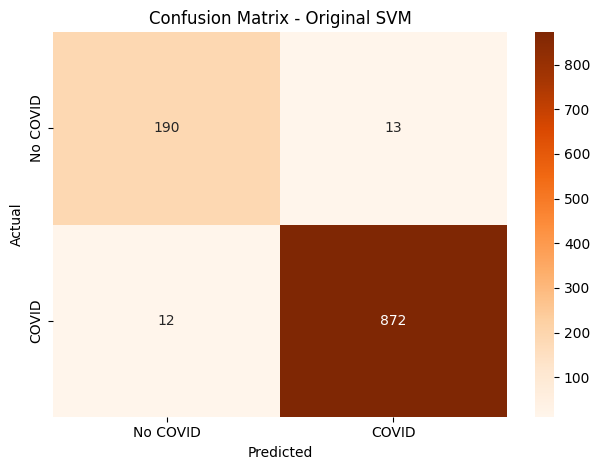

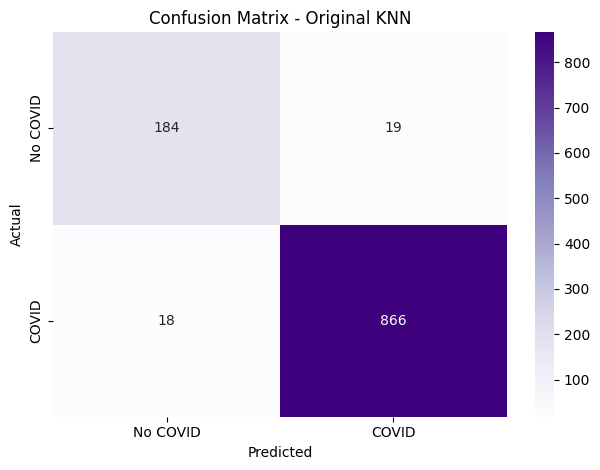

In [ ]:
# Confusion matrix for original SVM
cm_svm_orig = confusion_matrix(y_test, y_pred_original)
sns.heatmap(cm_svm_orig, annot=True, fmt='d', cmap='Oranges', xticklabels=['No COVID', 'COVID'], yticklabels=['No COVID', 'COVID'])
plt.title('Confusion Matrix - Original SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Confusion matrix for original KNN
cm_knn_orig = confusion_matrix(y_test, y_pred_knn_orig)
sns.heatmap(cm_knn_orig, annot=True, fmt='d', cmap='Purples', xticklabels=['No COVID', 'COVID'], yticklabels=['No COVID', 'COVID'])
plt.title('Confusion Matrix - Original KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# --- 🧪 2. RESAMPLED DATA (SMOTE) ---
print("\n================ SMOTE RESAMPLED DATA ================")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

svm_resampled = SVC(kernel='rbf', C=1, gamma=0.01)
svm_resampled.fit(X_train_scaled, y_train_bal)
y_pred_resampled = svm_resampled.predict(X_test_scaled)
print("\n🔍 SVM after SMOTE")
print(classification_report(y_test, y_pred_resampled))

knn_resampled = KNeighborsClassifier(n_neighbors=5)
knn_resampled.fit(X_train_scaled, y_train_bal)
y_pred_knn_res = knn_resampled.predict(X_test_scaled)
print("\n🔍 KNN after SMOTE")
print(classification_report(y_test, y_pred_knn_res))


================ SMOTE RESAMPLED DATA ================

🔍 SVM after SMOTE
              precision    recall  f1-score   support

           0       0.77      0.99      0.86       203
           1       1.00      0.93      0.96       884

    accuracy                           0.94      1087
   macro avg       0.88      0.96      0.91      1087
weighted avg       0.95      0.94      0.94      1087


🔍 KNN after SMOTE
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       203
           1       0.98      0.98      0.98       884

    accuracy                           0.97      1087
   macro avg       0.94      0.94      0.94      1087
weighted avg       0.97      0.97      0.97      1087



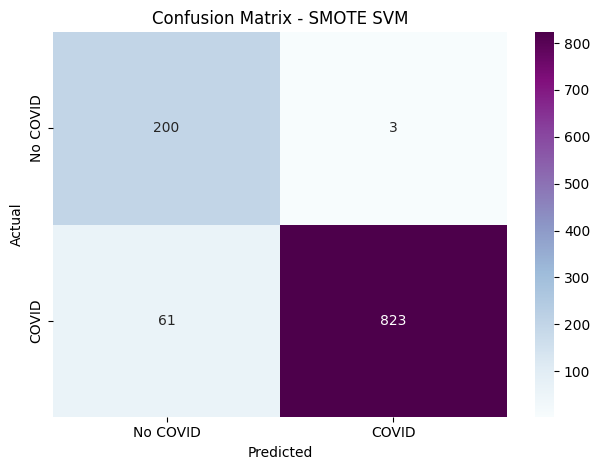

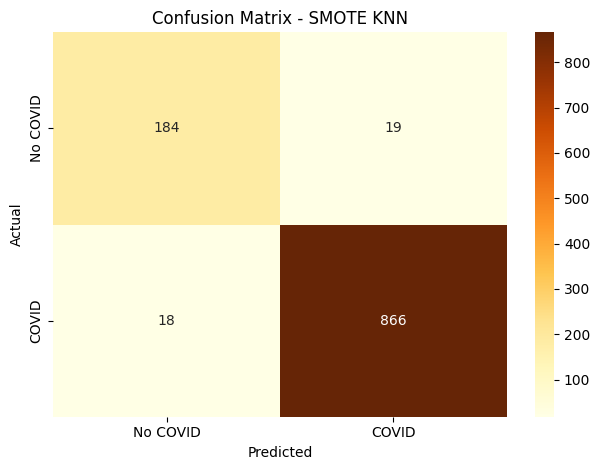

In [ ]:
# Confusion matrix for resampled SVM
cm_svm_smote = confusion_matrix(y_test, y_pred_resampled)
sns.heatmap(cm_svm_smote, annot=True, fmt='d', cmap='BuPu', xticklabels=['No COVID', 'COVID'], yticklabels=['No COVID', 'COVID'])
plt.title('Confusion Matrix - SMOTE SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Confusion matrix for resampled KNN
cm_knn_smote = confusion_matrix(y_test, y_pred_knn_res)
sns.heatmap(cm_knn_smote, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['No COVID', 'COVID'], yticklabels=['No COVID', 'COVID'])
plt.title('Confusion Matrix - SMOTE KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# --- 🔍 3. TUNED MODEL (GridSearchCV on SMOTE) ---
print("\n================ TUNED MODEL (GRID SEARCH) ================")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

svm_grid = GridSearchCV(SVC(class_weight='balanced'), param_grid_svm, cv=5, scoring='f1')
svm_grid.fit(X_train_scaled, y_train_bal)

print("\nBest SVM Parameters:", svm_grid.best_params_)
y_pred_svm_tuned = svm_grid.predict(X_test_scaled)
print("\n🔍 Tuned SVM")
print(classification_report(y_test, y_pred_svm_tuned))

# KNN Tuning
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_bal)
    y_pred_k = knn.predict(X_test_scaled)
    k_scores.append(accuracy_score(y_test, y_pred_k))

best_k = np.argmax(k_scores) + 1
knn_tuned = KNeighborsClassifier(n_neighbors=best_k)
knn_tuned.fit(X_train_scaled, y_train_bal)
y_pred_knn_tuned = knn_tuned.predict(X_test_scaled)
print(f"\n🔍 Tuned KNN (k={best_k})")
print(classification_report(y_test, y_pred_knn_tuned))


================ TUNED MODEL (GRID SEARCH) ================

Best SVM Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

🔍 Tuned SVM
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       203
           1       1.00      0.94      0.97       884

    accuracy                           0.95      1087
   macro avg       0.90      0.96      0.92      1087
weighted avg       0.96      0.95      0.95      1087


🔍 Tuned KNN (k=19)
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       203
           1       0.99      0.99      0.99       884

    accuracy                           0.98      1087
   macro avg       0.96      0.96      0.96      1087
weighted avg       0.98      0.98      0.98      1087



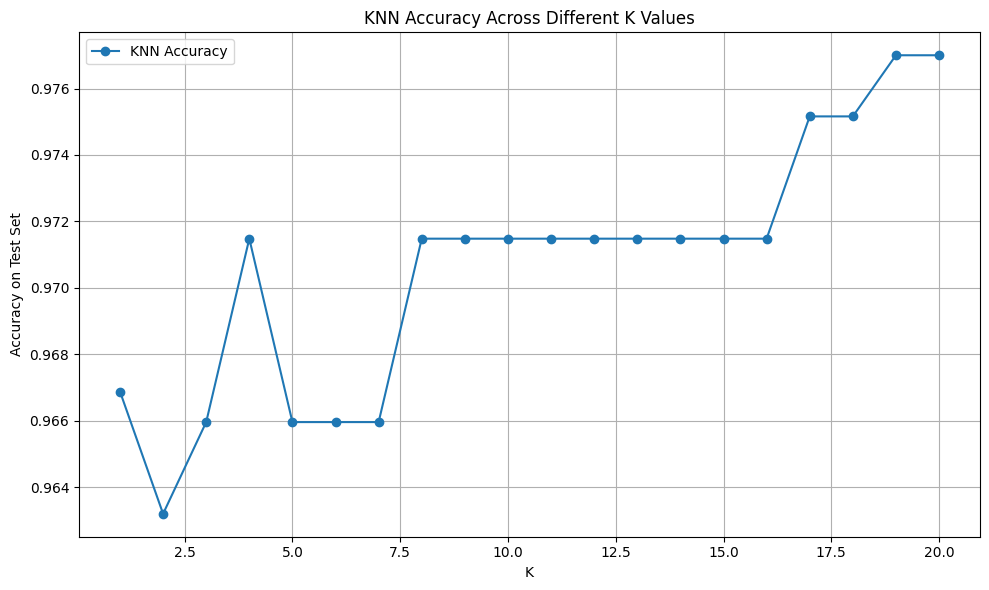

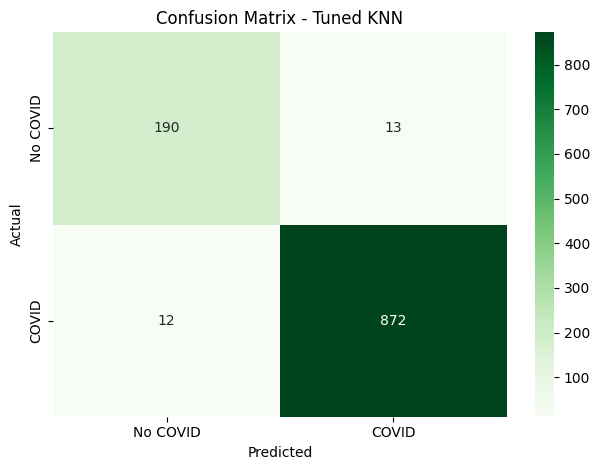

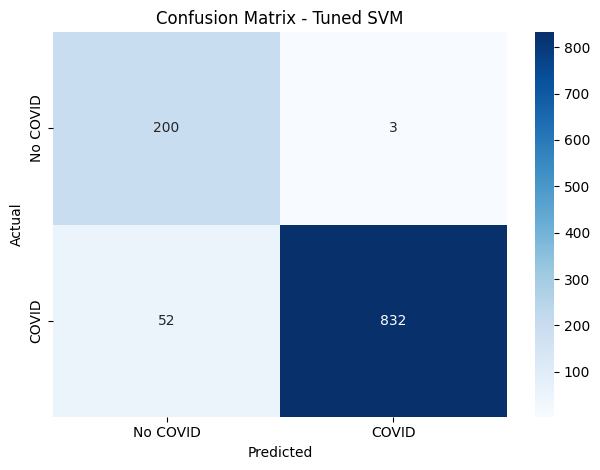

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), k_scores, marker='o', label='KNN Accuracy')
plt.title("KNN Accuracy Across Different K Values")
plt.xlabel("K")
plt.ylabel("Accuracy on Test Set")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix for tuned KNN
cm_knn_tuned = confusion_matrix(y_test, y_pred_knn_tuned)
sns.heatmap(cm_knn_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=['No COVID', 'COVID'], yticklabels=['No COVID', 'COVID'])
plt.title('Confusion Matrix - Tuned KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Confusion matrix for the final tuned SVM
cm = confusion_matrix(y_test, y_pred_svm_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No COVID', 'COVID'], yticklabels=['No COVID', 'COVID'])
plt.title('Confusion Matrix - Tuned SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
